In [67]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn import cross_validation
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import statsmodels.formula.api as sm

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Any results you write to the current directory are saved as output.

In [2]:
pd.options.display.max_columns = 999

In [3]:
train_data_ori = pd.read_csv('train.csv')
pd.options.display.max_rows = 999
train_data_ori.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data_ori = pd.read_csv('test.csv')

In [5]:
train_data = pd.concat([train_data_ori, test_data_ori]).reset_index(drop=True)

In [6]:
# Number of outcome classes
train_data['Survived'].value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

From the number of classess and their proportion, we can see that it is a binary classification problem with imbalanced category. Therefore, we need to consider using f1-score as the evalution metric

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
# Create function for extracting information from Name
import re
import string
def name_parsing(text):
    # Remove bracket content
    title = []
    middle_name = []
    last_name = []
    
    title_bank = ['Miss', 'Mr', 'Mrs', 'Dr', 'Master', 'Major', 'Rev', 'Capt', 'Lady',
       'Mme', 'Ms', 'Col', 'Mlle']
    
    for i in range(len(text)):
        # Remove the content in bracket
        text.iloc[i] = re.sub("[\(\[].*?[\)\]]", "", text.iloc[i])
        # Remove punctuation
        translation = text.iloc[i].maketrans("","", string.punctuation)
        # Split
        # ext_trans = text[i].translate(translation)
        text_split = text.iloc[i].split()
        lastname_flag = 0
        title_flag = 0
        for j in range(len(text_split)):
            if (',' in text_split[j]) & (lastname_flag == 0):
                last_name.append(text_split[j].translate(translation))
                last_name_flag = 1
            
            if ('.' in text_split[j]) & (title_flag == 0):
                title.append(text_split[j].translate(translation))                
                title_flag = 1                
    
        if last_name_flag == 0:
            last_name.append(np.nan)
        
        if title_flag == 0:
            title.append(np.nan)
            
        # first_name.append(text_split[-2].translate(translation))
        middle_name.append(text_split[-1].translate(translation))
        
    return pd.Series(title), pd.Series(last_name), pd.Series(middle_name)

In [9]:
# Map title name to represent better the gender and ages
title_map = {"Capt":       "Officer",
            "Col":        "Officer",
            "Major":      "Officer",
            "Jonkheer":   "Royalty",
            "Don":        "Royalty",
            "Sir" :       "Royalty",
            "Dr":         "Officer",
            "Rev":        "Officer",
            "the Countess":"Royalty",
            "Dona":       "Royalty",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Royalty"}

In [10]:
# Create function for name processing
def name_proc(data_frame, title_map):
    """
    Perfor processing on name column
    ------------------------------------
    Input: 
    name: Series containing name of the Passenger
    Output:
    One hot encoding of mapped titles using title_map
    """
    title, last, middle = name_parsing(data_frame['Name'])
    
    title = pd.Series(title)
    title = title.map(title_map)
    data_frame['title_name'] = title
    one_hot_title = pd.get_dummies(title, drop_first=True)
    
    data_frame.drop(labels='Name', axis=1, inplace=True)
    
    data_frame = data_frame.join(one_hot_title)
    
    return data_frame

In [11]:
train_data = name_proc(train_data, title_map)
#test_data = name_proc(test_data, title_map)

In [12]:
# Extract string and number information from ticket
def ticket_proc(data_frame):
    """
    Create columns with ticket letters and numbers
    ------------------------------------------------
    Input:
    Data frame with Ticket column
    Output:
    Data frame without Ticket column but with seperate letters and number informaiton
    """
    ticket_ori = data_frame['Ticket']

    ticket_num1 = []
    ticket_num2 = []
    ticket_str = []
    for tk in range(len(ticket_ori)):
        # Look for number in the string
        if len(re.findall(r'\d+', ticket_ori.iloc[tk])) ==0:
            ticket_num1.append(np.nan)
            ticket_num2.append(np.nan)
        else:
            ticket_num_temp = re.findall(r'\d+', ticket_ori.iloc[tk])
            if len(ticket_num_temp)>1:
                ticket_num1.append(np.int(ticket_num_temp[0]))
                ticket_num2.append(np.int(ticket_num_temp[-1]))
            else:
                ticket_num1.append(0)
                ticket_num2.append(np.int(ticket_num_temp[-1]))
        
        # Look for letters in the string
        if len(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk]))==0:
            ticket_str.append(np.nan)
        else:
            ticket_str.append(''.join(re.findall("[a-zA-Z]+", ticket_ori.iloc[tk])))
        
    data_frame = data_frame.join([pd.Series(ticket_num1, name='ticket_num1'), pd.Series(ticket_num2, name='ticket_num2'), pd.Series(ticket_str, name='ticket_str')])
    data_frame.drop(labels='Ticket', axis=1, inplace=True)

    return data_frame

In [13]:
train_data = ticket_proc(train_data)
#test_data = ticket_proc(test_data)

In [14]:
train_data.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,ticket_str
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,Mr,0,1,0,0,0,5.0,21171.0,A
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,Mrs,0,0,1,0,0,0.0,17599.0,PC
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,Miss,1,0,0,0,0,2.0,3101282.0,STONO
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,Mrs,0,0,1,0,0,0.0,113803.0,NaN
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,Mr,0,1,0,0,0,0.0,373450.0,NaN


In [15]:
# Convert categorical to numerical values for Sex
def sex_proc(data_frame):
    data_frame.loc[:,'Sex'] = data_frame.loc[:,'Sex'].map({'male':0, 'female':1})
    return data_frame

In [16]:
train_data = sex_proc(train_data)
#test_data = sex_proc(test_data)

In [17]:
# Fill embarked with most most common case
# Use Dummy Variabe encoding
def embarked_proc(data_frame):
    data_frame.loc[:, 'Embarked'] = data_frame.loc[:, 'Embarked'].fillna(data_frame['Embarked'].value_counts().index[0])
    one_hot_embarked = pd.get_dummies(data_frame['Embarked'], drop_first=True, prefix='Embarked')
    
    data_frame = data_frame.join(one_hot_embarked)
    data_frame.drop(labels='Embarked', axis=1, inplace=True)
    
    return data_frame

In [18]:
train_data = embarked_proc(train_data)
#test_data = embarked_proc(test_data)

In [19]:
train_data.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,ticket_str,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,0,1,3,0,1,0.0,Mr,0,1,0,0,0,5.0,21171.0,A,0,1
1,38.0,C85,71.2833,0,2,1,1,1,1.0,Mrs,0,0,1,0,0,0.0,17599.0,PC,0,0
2,26.0,NaN,7.9250,0,3,3,1,0,1.0,Miss,1,0,0,0,0,2.0,3101282.0,STONO,0,1
3,35.0,C123,53.1000,0,4,1,1,1,1.0,Mrs,0,0,1,0,0,0.0,113803.0,NaN,0,1
4,35.0,NaN,8.0500,0,5,3,0,0,0.0,Mr,0,1,0,0,0,0.0,373450.0,NaN,0,1


We performed exploratory analysis and see that for groups with the same cabin number, they are either one family or combined family. However, it is possible that the ones with 'Cabin' could tell us the location. So we will use the Letter.

In [20]:
def Cabin_proc(data_frame):
    cabin = data_frame['Cabin']
    
    cabin_let = []
    for i in range(len(cabin)):
        if cabin[i] is not np.nan:
            if len(re.findall("[a-zA-Z]+", cabin[i])) !=0:
                cabin_let.append(re.findall("[a-zA-Z]+", cabin[i])[0])
        else:
            cabin_let.append('Z')        # The original Cabin index does not have 'Z', we assgin 'Z' to represent nan         
    
    cabin_let = pd.Series(cabin_let, name='cabin_let')
    one_hot_cabin = pd.get_dummies(cabin_let, prefix='Cabin', drop_first=True)
    data_frame = data_frame.join(one_hot_cabin)
    data_frame.drop(labels='Cabin', axis=1, inplace=True)
            
    return data_frame

In [21]:
train_data = Cabin_proc(train_data)
#test_data = Cabin_proc(test_data)

In [22]:
# Keep only the major ticket numbers
def ticket_str_proc(data_frame):
    ticket_str_tmp = data_frame['ticket_str'].value_counts()
    
    for i in range(6,len(ticket_str_tmp)):
        data_frame.loc[data_frame['ticket_str']==ticket_str_tmp.index[i], 'ticket_str'] = np.nan
    
    data_frame.loc[:,'ticket_str'] = data_frame.loc[:,'ticket_str'].fillna('Nostr')
    
    one_hot_ticket_str = pd.get_dummies(data_frame['ticket_str'], prefix='ticket', drop_first=True)
    data_frame = data_frame.join(one_hot_ticket_str)
    data_frame.drop(labels='ticket_str', axis=1, inplace=True)
    
    return data_frame

In [23]:
train_data = ticket_str_proc(train_data)
#test_data = ticket_str_proc(test_data)

In [24]:
def fill_na_fare_age(data_frame):
    
    # Treat 0 fare as nan
    data_frame.loc[data_frame['Fare']<0.0001, 'Fare'] = np.nan
    
    # fill the nan values in Age and Fare
    data_frame["Age"] = data_frame.groupby(['Sex','Pclass','title_name'])['Age'].transform(lambda x: x.fillna(x.median()))
    data_frame["Fare"] = data_frame.groupby(['Sex','Pclass','title_name'])['Fare'].transform(lambda x: x.fillna(x.median()))
    
    return data_frame

In [25]:
train_data = fill_na_fare_age(train_data)
#test_data = fill_na_fare_age(test_data)

In [26]:
train_data['ticket_num2'].value_counts().head()

2343.0     11
1601.0      8
2144.0      8
14879.0     7
17608.0     7
Name: ticket_num2, dtype: int64

In [27]:
train_data[train_data['ticket_num2'] == 1601.0]

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC
74,32.0,56.4958,0,75,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
169,28.0,56.4958,0,170,3,0,0,0.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
509,26.0,56.4958,0,510,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
643,26.0,56.4958,0,644,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
692,26.0,56.4958,0,693,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
826,26.0,56.4958,0,827,3,0,0,0.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
838,32.0,56.4958,0,839,3,0,0,1.0,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
930,26.0,56.4958,0,931,3,0,0,NaN,Mr,0,1,0,0,0,0.0,1601.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [28]:
# Find the number of occurance for each ticket_num2
def add_occurance(data_frame):
    value_occ = pd.Series(data_frame['ticket_num2'].value_counts())
    value_occ_single = []
    for i in range(len(data_frame)):
        value_occ_tmp = data_frame.iloc[i]['ticket_num2']
        if np.isnan(value_occ_tmp):
            value_occ_single.append(1)
        else:
            # Confirm whether fare are shared across passengers with the same ticket number
            fare_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp, 'Fare']

            if len(fare_tmp.value_counts()) == 1:
                value_occ_single.append(value_occ[value_occ_tmp])
            else:
                value_occ_single.append(1)
                
    data_frame = data_frame.join(pd.Series(value_occ_single, name='occurance'), how='outer')
    
    return data_frame

In [29]:
train_data = add_occurance(train_data)
#test_data = add_occurance(test_data)

In [30]:
singleton = train_data[train_data['occurance']==1]

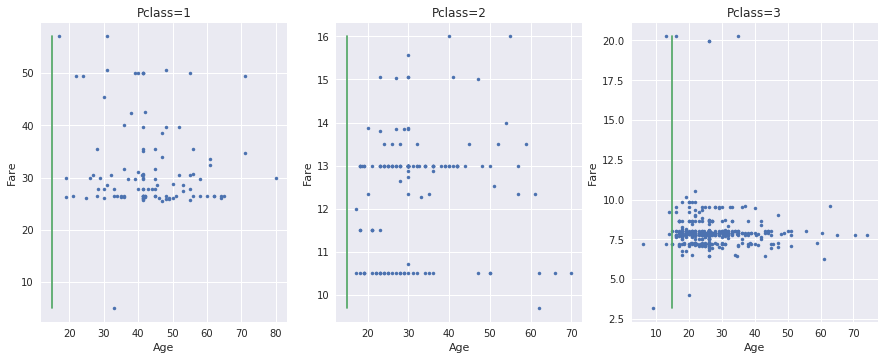

In [31]:
# For each Pclass, plot the relationship between Age and Fare for singleton
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
for i in range(3):
    singleton = train_data[(train_data['occurance'] == 1)&(train_data['Pclass'] == i+1)]
    ax[i].plot(singleton['Age'], singleton['Fare'],'.')
    ax[i].plot(np.ones(10) * 15, np.linspace(singleton['Fare'].min(), singleton['Fare'].max(), 10))
    ax[i].set_title('Pclass={a}'.format(a=i+1))
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Fare')

In [32]:
# Obtain the final fare for dividing the number of occurence
def update_fare(data_frame):
    value_occ = pd.DataFrame(data_frame['ticket_num2'].value_counts())
    for i in range(len(value_occ)):
        value_occ_tmp = value_occ.iloc[i].name
        if ~np.isnan(value_occ_tmp):
            # Confirm whether fare are shared across passengers with the same ticket number
            fare_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp, 'Fare']
            data_tmp = data_frame.loc[data_frame['ticket_num2'] == value_occ_tmp]

            if len(fare_tmp.value_counts()) == 1:
                young_len = len(data_tmp[data_tmp['Age'] < 15])
                old_len = len(data_tmp[data_tmp['Age'] >= 15])
                data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] < 15), 'Fare'] = data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] <15), 'Fare'] / (old_len * 2 + young_len)
                data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] >= 15), 'Fare'] = data_frame.loc[(data_frame['ticket_num2'] == value_occ_tmp)&(data_frame['Age'] >=15), 'Fare'] / (old_len * 2 + young_len)*2
                
    return data_frame

In [33]:
train_data = update_fare(train_data)
#test_data = update_fare(test_data)

In [34]:
train_data[train_data['ticket_num2'] == 2343.0]

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,title_name,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,ticket_num2,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance
159,6.0,3.4775,2,160,3,0,8,0.0,Master,0,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
180,18.0,6.9550,2,181,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
201,26.0,6.9550,2,202,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
324,26.0,6.9550,2,325,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
792,18.0,6.9550,2,793,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
846,26.0,6.9550,2,847,3,0,8,0.0,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
863,18.0,6.9550,2,864,3,1,8,0.0,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1079,18.0,6.9550,2,1080,3,1,8,NaN,Miss,1,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1233,26.0,6.9550,9,1234,3,0,1,NaN,Mr,0,1,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11
1251,14.5,3.4775,2,1252,3,0,8,NaN,Master,0,0,0,0,0,0.0,2343.0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,11


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 33 columns):
Age               1309 non-null float64
Fare              1309 non-null float64
Parch             1309 non-null int64
PassengerId       1309 non-null int64
Pclass            1309 non-null int64
Sex               1309 non-null int64
SibSp             1309 non-null int64
Survived          891 non-null float64
title_name        1308 non-null object
Miss              1309 non-null uint8
Mr                1309 non-null uint8
Mrs               1309 non-null uint8
Officer           1309 non-null uint8
Royalty           1309 non-null uint8
ticket_num1       1305 non-null float64
ticket_num2       1305 non-null float64
Embarked_Q        1309 non-null uint8
Embarked_S        1309 non-null uint8
Cabin_B           1309 non-null uint8
Cabin_C           1309 non-null uint8
Cabin_D           1309 non-null uint8
Cabin_E           1309 non-null uint8
Cabin_F           1309 non-null uint8
Cabin_G  

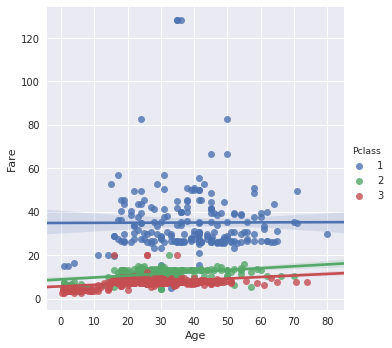

In [36]:
# Look into relationship between Age and Fare
sns.lmplot(x='Age', y='Fare', hue='Pclass', data=train_data[:892])

In [37]:
# sns.lmplot(x='Age', y='Fare', hue='Pclass', data=train_data[:892])

In [38]:
def drop_items(data_frame):
    data_frame.drop(labels='PassengerId', axis=1, inplace=True)
    data_frame.drop(labels='ticket_num2', axis=1, inplace=True)
    data_frame.drop(labels='title_name', axis=1, inplace=True)
    return data_frame

In [39]:
train_data = drop_items(train_data)
#test_data = drop_items(test_data)

In [40]:
train_data.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance
0,22.0,7.25000,0,3,0,1,0.0,0,1,0,0,0,5.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,38.0,35.64165,0,1,1,1,1.0,0,0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2
2,26.0,7.92500,0,3,1,0,1.0,1,0,0,0,0,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,35.0,26.55000,0,1,1,1,1.0,0,0,1,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2
4,35.0,8.05000,0,3,0,0,0.0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1


In [41]:
test = train_data.copy()
test['ticket_num1'].value_counts()

0.0    1237
5.0      28
2.0      25
4.0      13
3.0       2
Name: ticket_num1, dtype: int64

In [42]:
# Consider the large number of ticket being 0.0, we will group into 0.0 and non 0.0 group
def ticket_num1(data_frame):
    # Fill the nan in ticket_num1 and ticket_num2
    data_frame['ticket_num1'] = data_frame['ticket_num1'].fillna(0.0)
    data_frame['ticket_num1'] = data_frame['ticket_num1'].map(lambda x: 1.0 if x > 0.0 else 0.0)
    
    return data_frame

In [43]:
train_data = ticket_num1(train_data)
#test_data = ticket_num1(test_data)

In [44]:
#test_data.head()

In [45]:
def Pclass_proc(data_frame):
    one_hot_Pclass = pd.get_dummies(data_frame['Pclass'], prefix='Pclass', drop_first=True)
    data_frame = data_frame.join(one_hot_Pclass)
    data_frame.drop('Pclass', axis=1, inplace=True)
    return data_frame

In [46]:
train_data = Pclass_proc(train_data)
# test_data = Pclass_proc(test_data)

In [47]:
def add_features(data_frame):
    data_frame['group_size'] = data_frame['Parch'] + data_frame['SibSp'] + 1
    data_frame['Singleton'] = data_frame['group_size'].map(lambda x: 1 if x == 1 else 0)
    data_frame['SmallFamily'] = data_frame['group_size'].map(lambda x: 1 if 1 < x <5 else 0)
    data_frame['LargeFamily'] = data_frame['group_size'].map(lambda x: 1 if x > 4 else 0)
    data_frame['Young'] = data_frame['Age'].map(lambda x: 1 if x <15 else 0)
    data_frame['Old'] = data_frame['Age'].map(lambda x: 1 if x > 45 else 0)
    
    return data_frame

In [48]:
train_data = add_features(train_data)

In [49]:
train_data_final = train_data.iloc[:891,:]
test_data_final = train_data.iloc[891:, :]

In [50]:
y_train = train_data_final['Survived']
train_data_final.drop('Survived', axis=1, inplace=True)

In [51]:
train_data_final.head()

,Age,Fare,Parch,Sex,SibSp,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance,Pclass_2,Pclass_3,group_size,Singleton,SmallFamily,LargeFamily,Young,Old
0,22.0,7.25000,0,0,1,0,1,0,0,0,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,2,0,1,0,0,0
1,38.0,35.64165,0,1,1,0,0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,2,0,1,0,0,0
2,26.0,7.92500,0,1,0,1,0,0,0,0,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0
3,35.0,26.55000,0,1,1,0,0,1,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,2,0,1,0,0,0
4,35.0,8.05000,0,0,0,0,1,0,0,0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,0,0


Here, we will use the correlatin matrix to detect collinearity and use the variance inflation factor to detect multicollinearity

In [52]:
corr_mat = train_data_final.corr()
corr_mat

,Age,Fare,Parch,Sex,SibSp,Miss,Mr,Mrs,Officer,Royalty,ticket_num1,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Z,ticket_CA,ticket_Nostr,ticket_PC,ticket_SOTONOQ,ticket_STONO,ticket_WC,occurance,Pclass_2,Pclass_3,group_size,Singleton,SmallFamily,LargeFamily,Young,Old
Age,1.000000,0.389096,-0.184627,-0.100952,-0.267801,-0.303490,0.205098,0.203422,0.188543,0.072069,-0.014418,-0.107742,0.021889,0.106245,0.151943,0.145891,0.121897,-0.080269,-0.071651,0.039066,-0.279046,-0.081247,-0.044228,0.176003,-0.032266,-0.015743,-0.021290,-0.234145,0.021401,-0.362880,-0.275269,0.175425,-0.058852,-0.228804,-0.549386,0.683687
Fare,0.389096,1.000000,-0.042302,0.102198,-0.086808,0.007592,-0.071686,0.119387,0.103468,0.094945,-0.125602,-0.148475,-0.179001,0.462670,0.375445,0.191157,0.119958,-0.053904,-0.044899,0.049751,-0.646737,-0.104902,-0.186974,0.548490,-0.070608,-0.074761,-0.054491,0.045582,-0.129723,-0.602181,-0.080464,-0.095474,0.163132,-0.117322,-0.222031,0.242153
Parch,-0.184627,-0.042302,1.000000,0.245489,0.414838,0.102514,-0.333905,0.221318,-0.048211,-0.031809,-0.102045,-0.081228,0.060814,0.056498,0.030736,-0.019125,-0.016554,0.023694,0.072388,-0.015878,-0.036987,0.228435,-0.050709,-0.049451,-0.061983,-0.068016,0.134682,0.641581,-0.000734,0.015790,0.783111,-0.583398,0.265863,0.631523,0.369696,-0.050703
Sex,-0.100952,0.102198,0.245489,1.000000,0.114631,0.691548,-0.867334,0.552686,-0.089228,-0.014396,-0.105820,0.074115,-0.119224,0.109689,0.058649,0.079248,0.047003,0.008202,0.091031,-0.024728,-0.140391,0.006179,0.015566,0.073639,-0.078271,-0.022434,0.055216,0.181959,0.064746,-0.137143,0.200988,-0.303646,0.260747,0.102954,0.082103,-0.048664
SibSp,-0.267801,-0.086808,0.414838,0.114631,1.000000,0.084945,-0.250489,0.059941,-0.024712,-0.001402,-0.069807,-0.026354,0.068734,-0.034538,0.029251,-0.017575,-0.036865,0.001706,-0.001402,-0.015907,0.040460,0.357512,-0.111055,-0.046244,-0.062097,-0.039188,0.026776,0.730318,-0.055932,0.092548,0.890712,-0.584471,0.213225,0.730691,0.394953,-0.071019
Miss,-0.303490,0.007592,0.102514,0.691548,0.084945,1.000000,-0.599803,-0.207996,-0.073253,-0.034258,-0.074419,0.168720,-0.139126,0.065664,0.009098,0.017400,0.020736,0.007292,0.048688,-0.017100,-0.045347,-0.006178,0.010675,0.039932,-0.045206,0.005574,0.077244,0.131059,-0.027381,0.003366,0.109271,-0.050402,-0.007684,0.111105,0.202053,-0.125007
Mr,0.205098,-0.071686,-0.333905,-0.867334,-0.250489,-0.599803,1.000000,-0.479363,-0.168826,-0.078955,0.135349,-0.078338,0.112870,-0.114673,-0.047873,-0.049952,-0.031384,-0.048235,-0.078955,0.028510,0.137319,-0.062847,-0.018424,-0.061841,0.093621,0.041308,-0.038911,-0.295352,-0.088569,0.155907,-0.338014,0.396920,-0.292792,-0.223221,-0.350718,0.018799
Mrs,0.203422,0.119387,0.221318,0.552686,0.059941,-0.207996,-0.479363,1.000000,-0.058544,-0.027379,-0.056108,-0.091121,-0.000565,0.061767,0.072174,0.073034,0.042077,0.003936,0.068664,-0.013667,-0.121660,0.017713,0.004199,0.056977,-0.053352,-0.035726,-0.012963,0.099210,0.125093,-0.180630,0.151534,-0.357826,0.365088,0.014670,-0.118698,0.061751
Officer,0.188543,0.103468,-0.048211,-0.089228,-0.024712,-0.073253,-0.168826,-0.058544,1.000000,-0.009643,-0.034639,0.012618,-0.000902,0.073177,0.025924,0.014080,-0.027715,-0.017472,-0.009643,-0.004813,-0.054658,-0.031536,0.050019,-0.006752,-0.018790,-0.020619,-0.015298,-0.056802,0.084401,-0.159089,-0.040975,0.035074,-0.015279,-0.039269,-0.045715,0.221091
Royalty,0.072069,0.094945,-0.031809,-0.014396,-0.001402,-0.034258,-0.078955,-0.027379,-0.009643,1.000000,-0.016200,-0.020654,-0.071444,-0.015847,-0.017883,-0.013170,-0.012961,-0.008171,-0.004510,-0.002251,-0.043320,-0.014749,-0.052227,0.115935,-0.008787,-0.009643,-0.007155,-0.031762,-0.034258,-0.074401,-0.016849,-0.014093,0.024647,-0.018365,-0.021380,0.080159


In [53]:
def coll_ana(data_frame):
        
    corr_mat = data_frame.corr()
    vif_score = np.zeros((len(corr_mat)))
    
    # Add the constant column
    data_frame['Constant'] = np.ones((len(data_frame),1))
    
    for i in range(len(corr_mat)):

        # Assess collinearity
        corr_idx = corr_mat[(corr_mat[corr_mat.index[i]].abs()>0.8)&(corr_mat[corr_mat.index[i]].abs()<1.0)].index

        # Using the rest of the variable to fit parameter i
        data_fit = data_frame.copy()
        y = np.array(data_fit[corr_mat.index[i]])
        data_fit.drop(labels=corr_mat.index[i], axis=1, inplace=True)
        regressor = sm.OLS(endog=y, exog=data_fit).fit()
        vif_score[i] = 1/(1 - regressor.rsquared)
        
        if len(corr_idx)>0:
            print(corr_mat.index[i]+':{a}'.format(a=corr_idx))
            
    print(corr_mat.index)
    vif_Sr = pd.Series(vif_score, index=corr_mat.index)
    data_frame.drop('Constant', axis=1, inplace=True)
    
    return vif_Sr

In [54]:
vif_Sr = coll_ana(train_data_final)
vif_Sr

Sex:Index(['Mr'], dtype='object')
SibSp:Index(['group_size'], dtype='object')
Mr:Index(['Sex'], dtype='object')
occurance:Index(['group_size'], dtype='object')
group_size:Index(['SibSp', 'occurance', 'LargeFamily'], dtype='object')
Singleton:Index(['SmallFamily'], dtype='object')
SmallFamily:Index(['Singleton'], dtype='object')
LargeFamily:Index(['group_size'], dtype='object')
Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Miss', 'Mr', 'Mrs', 'Officer',
       'Royalty', 'ticket_num1', 'Embarked_Q', 'Embarked_S', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_Z', 'ticket_CA', 'ticket_Nostr', 'ticket_PC', 'ticket_SOTONOQ',
       'ticket_STONO', 'ticket_WC', 'occurance', 'Pclass_2', 'Pclass_3',
       'group_size', 'Singleton', 'SmallFamily', 'LargeFamily', 'Young',
       'Old'],
      dtype='object')


Age                4.234651
Fare               4.152775
Parch                   inf
Sex               79.402538
SibSp                   inf
Miss              59.137961
Mr                12.862625
Mrs               45.785665
Officer            2.070613
Royalty            1.382712
ticket_num1       15.638523
Embarked_Q         1.634227
Embarked_S         1.751848
Cabin_B            4.321037
Cabin_C            5.101742
Cabin_D            3.378045
Cabin_E            3.345543
Cabin_F            2.213432
Cabin_G            1.431094
Cabin_T            1.076537
Cabin_Z           14.659925
ticket_CA         15.869432
ticket_Nostr      51.359003
ticket_PC         22.422829
ticket_SOTONOQ     6.520626
ticket_STONO       1.629688
ticket_WC          4.713369
occurance          3.470366
Pclass_2           5.589239
Pclass_3           9.285886
group_size              inf
Singleton               inf
SmallFamily             inf
LargeFamily             inf
Young              3.081531
Old                2

We need to for sure remove variables that show direct correlation. We will test what will be a good strategy for RandomForest regressor.

We could see the problem of using vif to analyze relationship between continuous and category variable is that is it really easy to use the combination of continuous variable to explain the discrete variable.

In [55]:
def drop_multi(data_frame, list):
    for i in range(len(list)):
        data_frame.drop(labels=list[i], axis=1, inplace=True)
        
    return data_frame

In [56]:
train_data_fs1 = train_data_final.copy()
test_data_fs1 = test_data_final.copy()
# drop_list = ['SibSp', 'Parch', 'Mr', 'SmallFamily','LargeFamily', 'Cabin_Z','ticket_CA','ticket_Nostr','ticket_PC', 'occurance']
drop_list = ['SibSp', 'Parch', 'Mr', 'Mrs','Cabin_Z','ticket_CA','ticket_Nostr','ticket_PC', 'occurance']
train_data_fs1 = drop_multi(train_data_fs1, drop_list)

In [57]:
train_data_fs1.head()

,Age,Fare,Sex,Miss,Officer,Royalty,ticket_num1,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,ticket_SOTONOQ,ticket_STONO,ticket_WC,Pclass_2,Pclass_3,group_size,Singleton,SmallFamily,LargeFamily,Young,Old
0,22.0,7.25000,0,0,0,0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0,0,0
1,38.0,35.64165,1,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0
2,26.0,7.92500,1,1,0,0,1.0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0
3,35.0,26.55000,1,0,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0
4,35.0,8.05000,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0


In [58]:
vif_Sr_fs1 = coll_ana(train_data_fs1)
vif_Sr_fs1

group_size:Index(['LargeFamily'], dtype='object')
Singleton:Index(['SmallFamily'], dtype='object')
SmallFamily:Index(['Singleton'], dtype='object')
LargeFamily:Index(['group_size'], dtype='object')
Index(['Age', 'Fare', 'Sex', 'Miss', 'Officer', 'Royalty', 'ticket_num1',
       'Embarked_Q', 'Embarked_S', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'ticket_SOTONOQ', 'ticket_STONO',
       'ticket_WC', 'Pclass_2', 'Pclass_3', 'group_size', 'Singleton',
       'SmallFamily', 'LargeFamily', 'Young', 'Old'],
      dtype='object')


Age               4.092606
Fare              3.739914
Sex               2.537333
Miss              2.591992
Officer           1.094200
Royalty           1.074199
ticket_num1       1.670996
Embarked_Q        1.553549
Embarked_S        1.590160
Cabin_B           1.795480
Cabin_C           1.922060
Cabin_D           1.460080
Cabin_E           1.348544
Cabin_F           1.034417
Cabin_G           1.038898
Cabin_T           1.020865
ticket_SOTONOQ    1.047079
ticket_STONO      1.563653
ticket_WC         1.050852
Pclass_2          4.926154
Pclass_3          8.240589
group_size        7.500849
Singleton              inf
SmallFamily            inf
LargeFamily            inf
Young             2.192570
Old               2.486769
dtype: float64

In [59]:
X_train = train_data_fs1.copy()
X_test = drop_multi(test_data_fs1, drop_list)
X_test.drop('Survived', axis=1, inplace=True)

In [60]:
# Oversampling using SMOTE
# X_resampled, y_resampled = SMOTE().fit_sample(train_data_final, train_data_final['Survived'])
# X_train = pd.DataFrame(X_resampled.astype(int), columns=train_data_final.columns)
# print(sorted(Counter(y_resampled).items()))

For small sample size, I don't recommend using oversampling.

In [61]:
# X_train = train_data_final
# y_train = train_data_final['Survived']
# X_test = test_data_final

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=50, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

From the preliminary results with can see that even letting XGBboost to fill in nan by itself. The training error is still high. We therefore needs to perform error analysis.

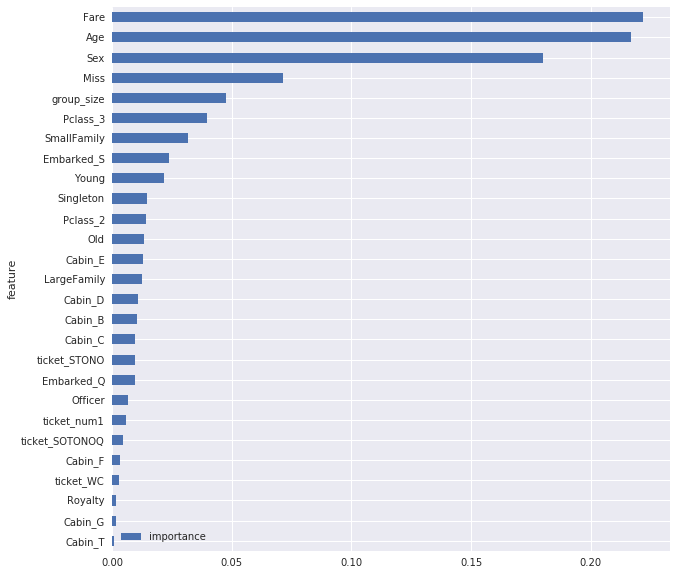

In [63]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(10, 10))

In [64]:
accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='accuracy', cv=5)
accuracies.mean()

0.80923743530983017

In [65]:
select_model = SelectFromModel(clf, prefit=True)
train_reduced = select_model.transform(X_train)
test_reduced = select_model.transform(X_test)
train_reduced.shape

(891, 6)

In [67]:
# Perform hyperparameter search for RandomForestClassifier
accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='accuracy', cv=5)
accuracies.mean()

0.80923743530983017

In [68]:
from sklearn.cross_validation import StratifiedKFold


parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [100, 80, 50],
             'max_features': ['sqrt', 'auto', 'log2'],
             'min_samples_split': [3, 10, 15],
             'min_samples_leaf': [1, 3],
             'bootstrap': [True, False],
             }
forest = RandomForestClassifier()
cross_validation = StratifiedKFold(y_train, n_folds=10)

grid_RF = GridSearchCV(forest,
                           scoring='accuracy',
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_RF.fit(X_train, y_train)
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

In [ ]:
# Refit with all the training data using best parameter
rf_final = RandomForestClassifier(**grid_search.best_params_)
rf_final.fit(X_train, y_train)

In [559]:
# Obtain the accuracy
rf_predict_train = rf_final.predict(X_train)
print('accuracy={}'.format(accuracy_score(rf_predict_train, y_train)))

accuracy=0.8698092031425365


In [ ]:
test_data_final.info()

In [560]:
# Predict on the test data
rf_predict_test = rf_final.predict(X_test)

In [561]:
# Save to working directory the correct format
output = pd.read_csv('output.csv')
output['Survived'] = rf_predict_test
output.to_csv('output.csv', index=False)

In [562]:
# df_output = pd.DataFrame()
# aux = pd.read_csv('test.csv')
# df_output['PassengerId'] = aux['PassengerId']
# df_output['Survived'] = rf_predict_test
# df_output[['PassengerId','Survived']].to_csv('output.csv',index=False)

Random forest, training accuracy: 0.87
We achieved a test accuracy of 0.799 using features with potential multicollinearity between sex and Ms, Mrs, and 0.77 with reduced feature.

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [660]:
X_test_scaled.shape

(418, 26)

In [623]:
# Now lets try logistic regression
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(random_state=0)

accuracies = cross_val_score(estimator=lg_clf, X=X_train_scaled, y=y_train, cv=10, scoring='accuracy')
accuracies.mean()

0.81150607195551017

In [624]:
# Perform hyperparameter search on logistic regression
parameters ={
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 500],
    'C': [0.8,1.0],
}

stratified_cv = StratifiedKFold(y_train, n_folds=10)

grid_lr = GridSearchCV(estimator=lg_clf, param_grid=parameters, cv=stratified_cv, scoring='accuracy')
grid_lr.fit(X_train, y_train)

parameters_lr = grid_lr.best_params_

print('Best scores:{a}'.format(a=grid_lr.best_score_))
print('Best parameters:{a}'.format(a=parameters_lr))

Best scores:0.8215488215488216
Best parameters:{'C': 0.8, 'max_iter': 100, 'solver': 'newton-cg'}


In [654]:
lg_clf = LogisticRegression(**parameters_lr)
lg_clf.fit(X_train_scaled, y_train)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [655]:
lg_train_predict = lg_clf.predict(X_train_scaled)
accuracy = accuracy_score(lg_train_predict, y_train)
accuracy

0.83052749719416386

In [686]:
# Predict on the test data
lg_predict_test = lg_clf.predict(X_test_scaled)

In [687]:
# Save to working directory the correct format
output = pd.read_csv('output.csv')
output['Survived'] = lg_predict_test
output.to_csv('output.csv', index=False)

Logistic regression: training accuracy of 0.83, testing accuracy of 0.77

In [664]:
from sklearn import svm

In [673]:
svm_clf = svm.SVC(kernel='rbf', cache_size=1000, random_state=0)
accuracies = cross_val_score(estimator=svm_clf, X=X_train_scaled, y=y_train, cv=stratified_cv)
accuracies.mean()

0.82275536261491311

In [674]:
# Perform hyperparameter search on logistic regression
parameters ={
    'kernel':['poly', 'rbf', 'sigmoid'],
    'C': [0.8,1.0],
}

grid_svm = GridSearchCV(estimator=svm_clf, param_grid=parameters, cv=stratified_cv, scoring='accuracy')
grid_svm.fit(X_train, y_train)

Best scores:0.8215488215488216
Best parameters:{'C': 0.8, 'max_iter': 100, 'solver': 'newton-cg'}


In [678]:
parameters_svm = grid_svm.best_params_

print('Best scores:{a}'.format(a=grid_svm.best_score_))
print('Best parameters:{a}'.format(a=parameters_svm))

Best scores:0.8305274971941639
Best parameters:{'C': 1.0, 'kernel': 'poly'}


In [685]:
svm_clf = svm.SVC(**parameters_svm)
svm_clf.fit(X_train_scaled, y_train)
svm_train_predict = svm_clf.predict(X_train_scaled)
accuracy = accuracy_score(svm_train_predict, y_train)
accuracy

0.86083052749719413

In [689]:
# Predict on the test data
svm_predict_test = svm_clf.predict(X_test_scaled)
# Save to working directory the correct format
output = pd.read_csv('output.csv')
output['Survived'] = svm_predict_test
output.to_csv('output.csv', index=False)

Kernal SVM: Training accuracy 0.86, testing accuracy 0.74

In [76]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier(n_neighbors=5)
stratified_cv=StratifiedKFold(y=y_train, n_folds=10, random_state=0)
accuracies = cross_val_score(estimator=kn_clf, X=X_train_scaled, y=y_train, cv=stratified_cv)
accuracies.mean()

0.80928441720576549

In [80]:
parameters={
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn_grid = GridSearchCV(estimator=kn_clf, param_grid=parameters, cv=stratified_cv, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 0.  1. ...,  1.  0.], n_folds=10, shuffle=False, random_state=0),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [81]:
knn_grid.best_params_

{'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'uniform'}

In [82]:
knn_grid.best_score_

0.81032547699214363

In [85]:
knn_clf = KNeighborsClassifier(**knn_grid.best_params_)
knn_clf.fit(X_train_scaled, y_train)
y_prediction = knn_clf.predict(X_train_scaled)
train_accuracy = accuracy_score(y_prediction, y_train)
print('training accuracy:{a}'.format(a=train_accuracy))

training accuracy:0.8641975308641975


In [87]:
knn_predict_test = knn_clf.predict(X_test_scaled)
# Save to working directory the correct format
output = pd.read_csv('output.csv')
output['Survived'] = knn_predict_test
output.to_csv('output.csv', index=False)

KNN: training accuracy of 0.86, testing accuracy of 0.73, strong overfitting

In [96]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
accuracies = cross_val_score(estimator=nb_clf, X=X_train, y=y_train, cv=stratified_cv, scoring='accuracy')
print('mean accuracy:{a}'.format(a=accuracies.mean()))
print('std accuracy:{a}'.format(a=accuracies.std()))

mean accuracy:0.6364615253660197
std accuracy:0.09961534146359556


From the poor performance score we can see that Gaussian NB assumes that the feature distributin conditioned on response variable following Gaussian distribution. This is not the case for us.

### Trying using artificial neural network

In [148]:
X_train_scaled.shape, y_train.shape

((891, 27), (891,))

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
scaler2 = StandardScaler()
X_reduced_scaled = scaler2.fit_transform(train_reduced)

In [80]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [100]:
def build_ANN(layer, input_u, hidden_u, drop_r=0.2, initialier ='uniform', opt='adam'):
    
    clf = Sequential()
    
    clf.add(Dense(activation='relu', units=hidden_u, kernel_initializer=initialier, input_dim=input_u))
    clf.add(Dropout(rate=drop_r))
    
    for i in range(layer-1):
        clf.add(Dense(activation='relu', units=hidden_u, kernel_initializer=initialier))
        clf.add(Dropout(rate=drop_r))
        
    clf.add(Dense(activation='sigmoid', units=1, kernel_initializer=initialier))
                
    clf.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return clf

In [82]:
classifier = KerasClassifier(build_fn=build_ANN, batch_size=32, epochs=100, input_u=6)
stratified_cv = StratifiedKFold(y_train, n_folds=10)
accuracies = cross_val_score(estimator=classifier, X=X_reduced_scaled, y=y_train, cv=stratified_cv, scoring='accuracy')

Epoch 1/100
801/801 [==============================] - 1s 934us/step - loss: 0.6918 - acc: 0.6242
Epoch 2/100
801/801 [==============================] - 0s 75us/step - loss: 0.6886 - acc: 0.6167
Epoch 3/100
801/801 [==============================] - 0s 74us/step - loss: 0.6841 - acc: 0.6167
Epoch 4/100
801/801 [==============================] - 0s 77us/step - loss: 0.6744 - acc: 0.6167
Epoch 5/100
801/801 [==============================] - 0s 83us/step - loss: 0

In [83]:
accuracies.mean(), accuracies.std()

(0.82717455453410516, 0.028415151094065408)

In [102]:
X_reduced_scaled.shape

(891, 6)

In [104]:
parameters = {
    'layer': [2,4,6],
    'hidden_u': [4,6,8],
    'drop_r': [0.1, 0.2],
    'epochs': [100, 200],
    'batch_size': [16, 32],
    'opt': ['adam', 'RMSprop'],
}

classifier = KerasClassifier(build_fn=build_ANN, input_u=6, verbose=0)
stratified_cv = StratifiedKFold(y_train, n_folds=10)
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, cv=stratified_cv, scoring='accuracy')
grid_search.fit(X_reduced_scaled, y_train)

KeyboardInterrupt: 